In [1]:
from backtest.polymarket_fetcher import *
import os

In [2]:
config = {
    "private_key": os.getenv("POLYMARKET_PRIVATE_KEY"),
    "funder": os.getenv("POLYMARKET_FUNDER"),
}

exchange = PolymarketFetcher(config)
print(f"Polymarket time-series ready ({'authenticated' if exchange.private_key else 'public'})")

Polymarket time-series ready (authenticated)


In [15]:
"""
Simple, opinionated search on top of Gamma /markets.

Gamma-side filters (API-level filtering, executed server-side):
    These filters are sent directly to the Gamma /markets endpoint,
    meaning the remote API performs the filtering before results are returned.

    - tag_id
        → /markets?tag_id=<id>

    - closed
        → /markets?closed=true/false
        Default: false (i.e., only open markets)

    - extra params via `params`
        Any user-supplied key/value pairs passed to the Gamma API request.
        Examples:
            - limit, offset (pagination control)
            - event_id, sort, status, etc.

Client-side filters (executed locally after markets are fetched):
    These operate on the full Market objects returned by Gamma,
    and are evaluated entirely within Python.

    - binary
        → Keep only markets where `market.is_binary == binary`.

    - min_liquidity
        → Keep only markets where `market.liquidity >= min_liquidity`.

    - categories (via metadata)
        → Matches against metadata fields like:
            * category
            * categories[]
            * topics[]
        Extracted using `_extract_categories(market)`.

    - outcomes (by name)
        → Checks that all given outcome strings appear in `market.outcomes`.

    - query (single substring search)
        → Case-insensitive substring search across the combined text
          produced by `_build_search_text(market)`.

          `_build_search_text()` collects:
              - market.question
              - metadata["description"]
              - metadata fields:
                    "slug",
                    "category",
                    "subtitle",
                    "seriesSlug",
                    "series",
                    "seriesTitle",
                    "seriesDescription",
                    "tags",
                    "topics",
                    "categories"

          The above are normalized to lowercase and concatenated into
          a single search text. Example fields Gamma may provide in metadata:
              - description
              - category
              - seriesSlug
              - tags (array)
              - topics (array)
              - categories (array)

          Then the filter checks:
              query.lower() in search_text

    - keywords (AND over multiple substrings)
        → Like `query`, but ALL keywords must appear in the same
          `_build_search_text(market)` output.

          Equivalent to:
              all(k in search_text for k in keyword_lowers)

    - predicate (custom callable)
        → An arbitrary Python function taking Market → bool.
          If provided, the market is kept only if predicate(m) returns True.
"""

crypto_tag = exchange.get_tag_by_slug('crypto')
crypto_hourly = exchange.get_tag_by_slug('1H')
crypto_15min = exchange.get_tag_by_slug('15M')
crypto_daily = exchange.get_tag_by_slug('today')
crypto_hit = exchange.get_tag_by_slug('hit-price')
election = exchange.get_tag_by_slug('election')

markets = exchange.search_markets(
        tag_id=crypto_15min.id,
        closed=False,
        keywords = ['bitcoin', 'up or down'],
        binary=True,
        min_liquidity=0.0,
        limit=100,
    )

markets

[Market(id='686629', question='Bitcoin Up or Down - November 18, 3:15AM-3:30AM ET', outcomes=['Up', 'Down'], close_time=datetime.datetime(2025, 11, 18, 8, 30, tzinfo=datetime.timezone.utc), volume=14365.27392, liquidity=99762.8059, prices={'Up': 0.505, 'Down': 0.495}, metadata={'id': '686629', 'question': 'Bitcoin Up or Down - November 18, 3:15AM-3:30AM ET', 'conditionId': '0xde3466a45bc0b3d393c766a908ad97c40cbdc25e2bca12c8d6e09b4742f12c5d', 'slug': 'btc-updown-15m-1763453700', 'resolutionSource': 'https://data.chain.link/streams/btc-usd', 'endDate': '2025-11-18T08:30:00Z', 'liquidity': '99762.8059', 'startDate': '2025-11-17T08:17:56.001963Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png', 'description': 'This market will resolve to "Up" if the Bitcoin price at the end of the time range specified in the title is greater than or equal to the price at the beginning of that 

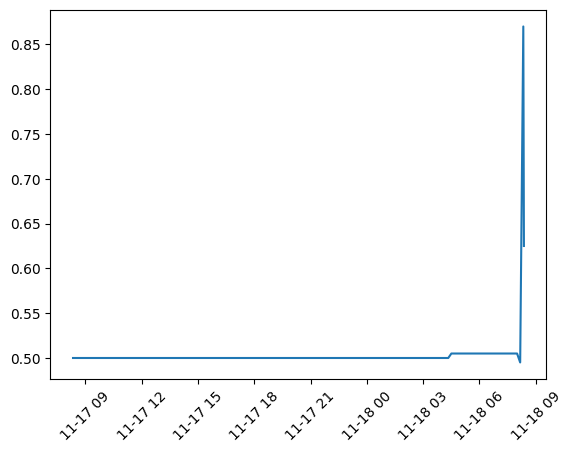

In [16]:
import matplotlib.pyplot as plt

target_market = markets[0]

df = exchange.fetch_price_history(target_market, interval="max", fidelity=1, as_dataframe=True)
plt.plot(df['timestamp'], df['price'])
plt.xticks(rotation=45)
plt.show()

In [12]:
aespakarina = '0xca85f4b9e472b542e1df039594eeaebb6d466bf2'
tmp_market='0xbb877d541d16896757c57107abe0632450ce1bedb4a46d4eae8ba1d1978207a6'

user_trades = exchange.fetch_public_trades(market=tmp_market, user=aespakarina, limit=1000)

In [13]:
import pandas as pd
from dataclasses import asdict

df_raw = pd.DataFrame([asdict(x) for x in user_trades])
df = df_raw[['side', 'size', 'price', 'timestamp', 'title', 'outcome']]
df_down = df[df['outcome']=='Down']
df_up = df[df['outcome']=='Up']

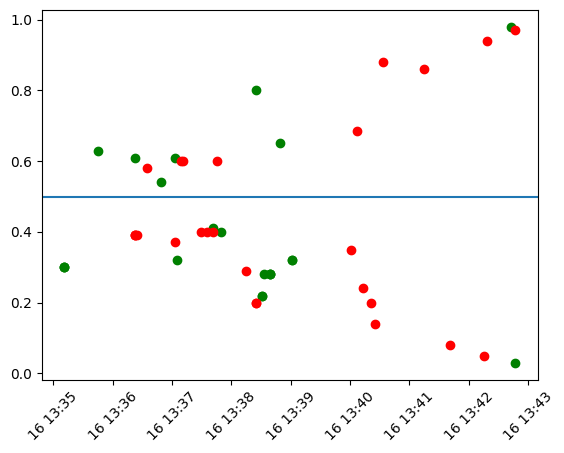

In [14]:
def plot(df):
    plt.scatter(df[df['side']=='BUY']['timestamp'], df[df['side']=='BUY']['price'], color='green')
    plt.scatter(df[df['side']=='SELL']['timestamp'], df[df['side']=='SELL']['price'], color='red')
    plt.xticks(rotation=45)

plot(df_up)
plot(df_down)
plt.axhline(0.5)